# Loading the libraries

In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Preparing the dataset

In [2]:
#fetch the mnist dataset
x, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
print(x.shape,y.shape)

(70000, 784) (70000,)


In [3]:
#x_n = x.to_numpy()
x_n = x
#y_n = y.to_numpy()
y_n = y

In [4]:
y_n = y_n.astype('int') #convert output to integers 0-9
x_norm = x_n/255.0 #normalise input data
x_train, x_val, y_train, y_val = train_test_split(x_norm, y_n, test_size=0.1, random_state=42) #split the data into train and validation
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

x_train = x_train.T #take the transpose of the training data m*784 -> 784*m
x_val = x_val.T #take the transpose of the test data m*784 -> 784*m
print(x_train.shape, x_val.shape)

(63000, 784) (7000, 784) (63000,) (7000,)
(784, 63000) (784, 7000)


# Defining the functions(GENERAL)

## Parameter initialization

In [5]:
def params_init(seed=2):

  np.random.seed(seed)
  W1 = np.random.rand(20,784) - 0.5
  b1 = np.random.rand(20,1) - 0.5
  W2 = np.random.rand(10,20) - 0.5 
  b2 = np.random.rand(10,1) - 0.5 
  print("Params Initialised")

  return (W1, b1, W2, b2)

## Other generic functions egs-loss

In [6]:

def predictions(A):
  #argmax returns the index of maximum value, we will feed the sigmoid output to this function 
  return np.argmax(A,0)


def accuracy(A,Y):
  #this will compare the predicted output to the ground truth
  return np.sum(A == Y)/(Y.shape[0])*100

In [7]:
def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  #return np.exp(Z) / np.sum(np.exp(Z),0)
  Z = Z-np.max(Z, axis=0)
  return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0

def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T

def crossEntropy(y,y_pre):
  loss=-np.sum(np.multiply(y, np.log(y_pre)), axis = 0)
  return loss

## Forward pass

In [8]:
def forward(x_train, W1, b1, W2, b2):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2
  A2 = softmax(Z2)
  

  return Z1, A1, Z2, A2

## Param update

In [9]:
def param_update(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))


  return W1, b1, W2, b2

# Back propagation

In [10]:
def backprop(Z1, A1, Z2, A2, W1, W2, X, y):
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ2 = (A2 - Y)
  
  dW2 = 1/m*np.matmul(dZ2,A1.T)

  db2 = 1/m*np.sum(dZ2, axis=1)

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis=1) #db1 is 50*1


  return dW1, db1, dW2, db2

# Quantization related functions

In [11]:
def roundArbitrary(weightArray, step, wRange):
    #wRange is added for the clipping component 

    weightArrayDiv = np.clip(weightArray, a_min = -wRange, a_max = wRange)
    weightArrayDiv = weightArrayDiv / step
    weightArrayDiv = np.round(weightArrayDiv)
    return weightArrayDiv*step

# Weight Perturbation

In [12]:
def WP(W1, b1, W2, b2, pert, lossBeforePert, X, y):
    m = y.shape[0] #m is the number of training examples
    Y = one_hot_encoding(y)
    dW1 = np.zeros_like(W1)
    lossAfterPertW1 = np.zeros_like(W1)
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W1pert = W1.copy()
            W1pert[i, j] += pert
            _, _, _, A2pert = forward(X, W1pert, b1, W2, b2)
            lossAfterPertW1[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    dW1 = 1/m * (lossAfterPertW1-lossBeforePert)/pert


    db1 = np.zeros_like(b1)
    lossAfterPertb1 = np.zeros_like(b1)
    for i in range(b1.shape[0]):
        b1pert = b1.copy()
        b1pert[i]+=pert
        _, _, _, A2pert = forward(X, W1, b1pert, W2, b2)
        lossAfterPertb1[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    db1 = 1/m * (lossAfterPertb1-lossBeforePert)/pert

    
    dW2 = np.zeros_like(W2)
    lossAfterPertW2 = np.zeros_like(W2)
    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W2pert = W2.copy()
            W2pert[i, j] += pert
            _, _, _, A2pert = forward(X, W1, b1, W2pert, b2)
            lossAfterPertW2[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    dW2 = 1/m * (lossAfterPertW2-lossBeforePert)/pert


    db2 = np.zeros_like(b2)
    lossAfterPertb2 = np.zeros_like(b2)
    for i in range(b2.shape[0]):
        b2pert = b2.copy()
        b2pert[i]+=pert
        _, _, _, A2pert = forward(X, W1, b1, W2, b2pert)
        lossAfterPertb2[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    db2 = 1/m * (lossAfterPertb2-lossBeforePert)/pert

    return dW1, db1, dW2, db2
            

In [13]:
def batchGradDescentWPQaunt(X,Y,iter, lr, pert, precision, step, wRange, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2 = params_init(2)
  W1 = roundArbitrary(W1, step, wRange)#weights have to maintained as their digitized versions
  b1 = roundArbitrary(b1, step, wRange)
  W2 = roundArbitrary(W2, step, wRange)
  b2 = roundArbitrary(b2, step, wRange)
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(15): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      Z1, A1, Z2, A2 = forward(X1, W1, b1, W2, b2) 
      print(f"BP Iter {i+1} -> sub iter {j} : {accuracy(predictions(A2), Y1)}", end = "\r", flush = True)

      #dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)
      loss = np.sum(crossEntropy(one_hot_encoding(Y1), A2))
      dW1, db1, dW2, db2 = WP(W1, b1, W2, b2, pert=pert, lossBeforePert=loss, X=X1, y=Y1)



      dW1round = roundArbitrary(dW1, step, wRange)#weights have to maintained as their digitized versions
      db1round = roundArbitrary(db1, step, wRange)
      dW2round = roundArbitrary(dW2, step, wRange)
      db2round = roundArbitrary(db2, step, wRange)


      W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1round, db1round, dW2round, db2round,  lr = lr)


    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _,  A2_train = forward(X, W1, b1, W2, b2)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,   A2_val = forward(x_val, W1, b1, W2, b2)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [14]:
precision = 10#setting the precision value of the calculations
wRange = 5
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels

In [39]:
batchGradDescentWPQaunt(x_train,y_train, iter=5, lr=1, pert=step, precision=precision, step=step, wRange = wRange, print_op=1)

Params Initialised


KeyboardInterrupt: 

In [40]:
precision = [2, 4, 8, 16, 32, 64]
wRange = 5
noOfLevels = [2**precision - 1 for precision in precision] #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  [wRange/nOL for nOL in noOfLevels]

trainAcc = []
valAcc = []
trainLoss = []
valLoss = []
sW = []
for i in range(len(precision)):
    _, _, _, _, train_acc, val_acc, train_loss, val_loss, sum_weights = batchGradDescentWPQaunt(x_train,y_train, iter=5, lr=1, pert=step[i], precision=precision[i], step=step[i], wRange = wRange, print_op=1)
    trainAcc.append(train_acc)
    valAcc.append(val_acc)
    trainLoss.append(train_loss)
    valLoss.append(val_loss)
    sW.append(sum_weights)
    print("--Done{i}")


Params Initialised
Iteration: 1 sub iter 99 : 10.026984126984133
Train accuracy: 9.873015873015872
Val accuracy: 9.757142857142858
Iteration: 2 sub iter 99 : 10.026984126984133
Train accuracy: 9.873015873015872
Val accuracy: 9.757142857142858
Iteration: 3 sub iter 99 : 10.026984126984133
Train accuracy: 9.873015873015872
Val accuracy: 9.757142857142858
Iteration: 4 sub iter 99 : 10.026984126984133
Train accuracy: 9.873015873015872
Val accuracy: 9.757142857142858
Iteration: 5 sub iter 99 : 10.026984126984133
Train accuracy: 9.873015873015872
Val accuracy: 9.757142857142858
--Done{i}
Params Initialised
Iteration: 1 sub iter 99 : 27.460317460317462
Train accuracy: 33.66984126984127
Val accuracy: 33.01428571428571
Iteration: 2 sub iter 99 : 33.809523809523818
Train accuracy: 35.095238095238095
Val accuracy: 35.17142857142857
Iteration: 3 sub iter 99 : 33.015873015873014
Train accuracy: 30.674603174603178
Val accuracy: 30.942857142857143
Iteration: 4 sub iter 99 : 32.539682539682546
Train a

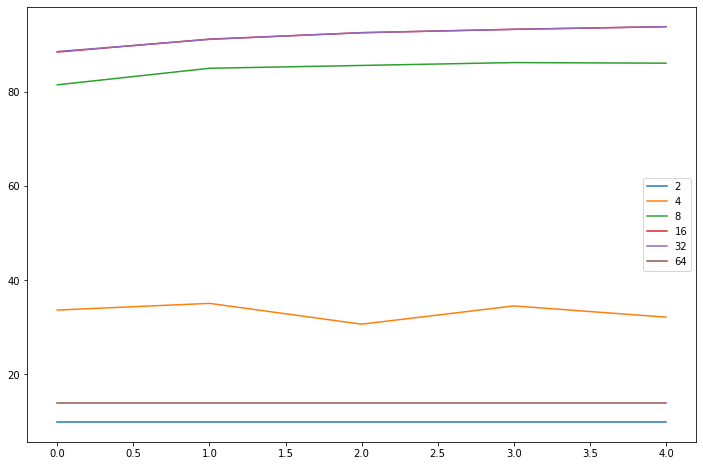

In [44]:
plt.figure(figsize = (12, 8))
for i in trainAcc:
    plt.plot(i)
plt.legend(precision)

In [16]:
precision = [16]
w1Arr = []
wRange = 1
noOfLevels = [2**precision - 1 for precision in precision] #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  [wRange/nOL for nOL in noOfLevels]

trainAcc1 = []
valAcc1 = []
trainLoss1 = []
valLoss1 = []
sW1 = []
for i in range(len(precision)):
    W1, _, _, _, train_acc, val_acc, train_loss, val_loss, sum_weights = batchGradDescentWPQaunt(x_train,y_train, iter=5, lr=1, pert=step[i], precision=precision[i], step=step[i], wRange = wRange, print_op=1)
    w1Arr.append(W1)
    trainAcc1.append(train_acc)
    valAcc1.append(val_acc)
    trainLoss1.append(train_loss)
    valLoss1.append(val_loss)
    sW1.append(sum_weights)
    print(f"--Done{i}")


Params Initialised
Iteration: 1 sub iter 14 : 62.857142857142854
Train accuracy: 65.75396825396825
Val accuracy: 66.12857142857142
Iteration: 2 sub iter 14 : 67.93650793650794
Train accuracy: 77.44285714285715
Val accuracy: 77.05714285714286
Iteration: 3 sub iter 14 : 84.28571428571429
Train accuracy: 81.07142857142857
Val accuracy: 81.61428571428571
Iteration: 4 sub iter 14 : 86.19047619047619
Train accuracy: 81.92857142857143
Val accuracy: 81.88571428571429
Iteration: 5 sub iter 14 : 88.73015873015872
Train accuracy: 86.10952380952381
Val accuracy: 85.9857142857143
--Done0


In [ ]:
plt.figure()
plt.subplot(131)
plt.plot(w1Arr[0].flatten(), '.')
plt.title(f"Precision  = f{precision[0]}")
# plt.subplot(132)
# plt.plot(w1Arr[1].flatten(), '.')
# plt.title(f"Precision  = f{precision[1]}")
# plt.subplot(133)
# plt.plot(w1Arr[2].flatten(), '.')
# plt.title(f"Precision  = f{precision[2]}")

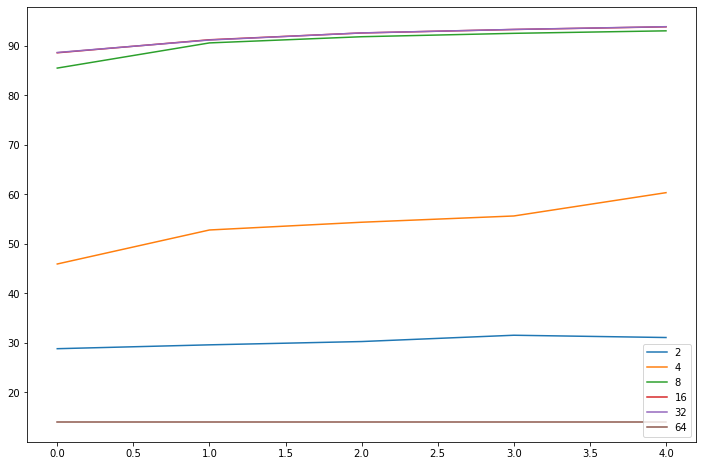

In [ ]:
plt.figure(figsize = (12, 8))
for i in trainAcc1:
    plt.plot(i)
plt.legend(precision)

In [ ]:
step

[0.3333333333333333,
 0.06666666666666667,
 0.00392156862745098,
 1.5259021896696422e-05,
 2.3283064370807974e-10,
 5.421010862427522e-20]

## Ideal WP

In [52]:
def batchGradDescentWP(X,Y,iter, lr, pert, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2 = params_init(2)
  
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      Z1, A1, Z2, A2 = forward(X1, W1, b1, W2, b2) 
      print(f"BP Iter {i+1} -> sub iter {j} : {accuracy(predictions(A2), Y1)}", end = "\r", flush = True)

      #dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)
      loss = np.sum(crossEntropy(one_hot_encoding(Y1), A2))
      dW1, db1, dW2, db2 = WP(W1, b1, W2, b2, pert=pert, lossBeforePert=loss, X=X1, y=Y1)



      W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)


    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _,  A2_train = forward(X, W1, b1, W2, b2)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,   A2_val = forward(x_val, W1, b1, W2, b2)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [53]:
W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights = batchGradDescentWP(x_train,y_train, iter=5, lr=1, pert=0.0001, print_op=1)

Params Initialised
Iteration: 1 sub iter 99 : 88.095238095238094
Train accuracy: 88.65714285714286
Val accuracy: 88.67142857142856
Iteration: 2 sub iter 99 : 91.42857142857143
Train accuracy: 91.21428571428571
Val accuracy: 90.95714285714286
Iteration: 3 sub iter 99 : 93.01587301587301
Train accuracy: 92.60000000000001
Val accuracy: 92.28571428571428
Iteration: 4 sub iter 99 : 93.49206349206354
Train accuracy: 93.32222222222222
Val accuracy: 92.74285714285713
Iteration: 5 sub iter 99 : 93.65079365079364
Train accuracy: 93.84920634920636
Val accuracy: 93.07142857142857


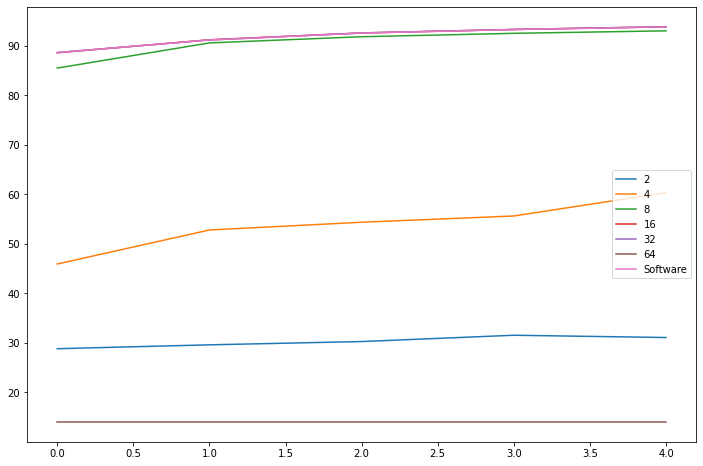

In [59]:
#leg = ["2", "4", "8", "16", "32", "64", "Software"]
leg = []
plt.figure(figsize = (12, 8))
for i in range(len(trainAcc1)):
    leg.append(str(precision[i]))
    plt.plot(trainAcc1[i])


leg.append("Software")
plt.plot(train_acc)
plt.legend(leg)

Text(0, 0.5, 'Accuaracy(%) ->')

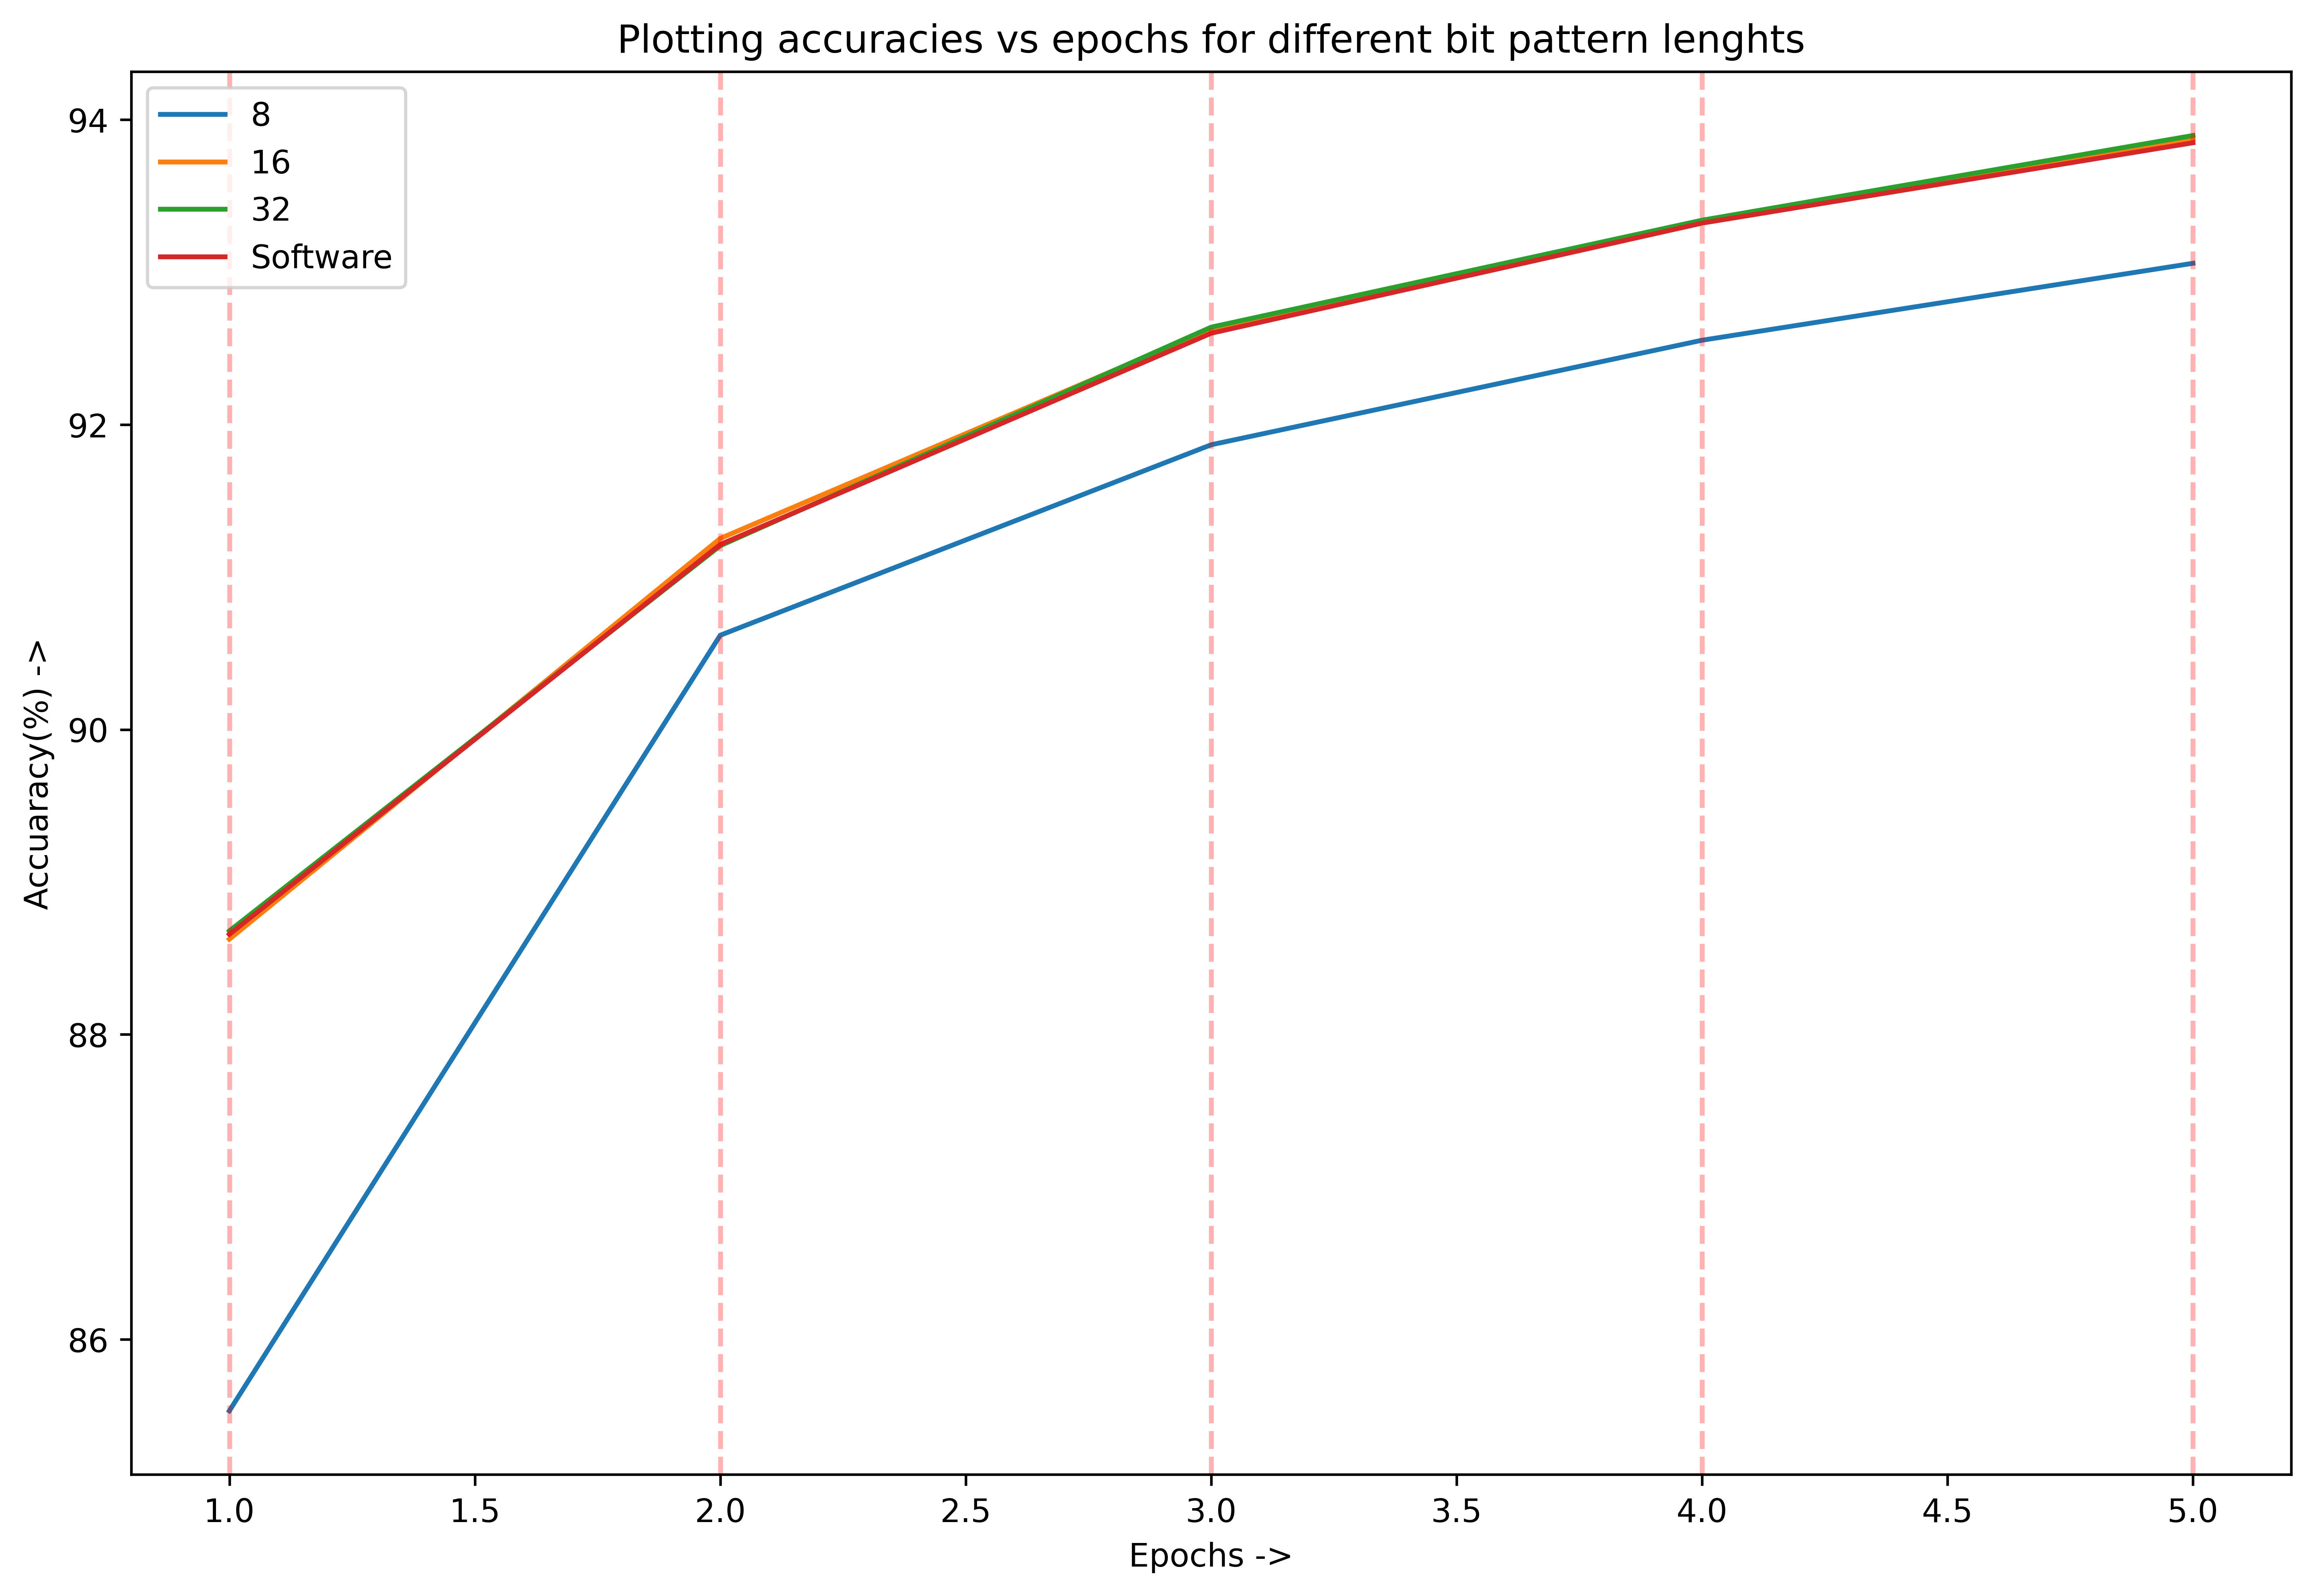

In [83]:
plt.rcParams['figure.dpi'] = 600
leg = []
epoch = [1, 2, 3, 4, 5]
plt.figure(figsize = (12, 8))


for i in [2, 3, 4]:
    leg.append(str(precision[i]))
    plt.plot(epoch, trainAcc1[i])


leg.append("Software")
plt.plot(epoch, train_acc)

for ep in epoch:
    plt.axvline(ep, color = 'r', alpha = 0.3, linestyle = '--')

    

plt.legend(leg)
plt.title("Plotting accuracies vs epochs for different bit pattern lenghts")
plt.xlabel("Epochs ->")
plt.ylabel("Accuaracy(%) ->")

Text(0, 0.5, 'Accuaracy(%) ->')

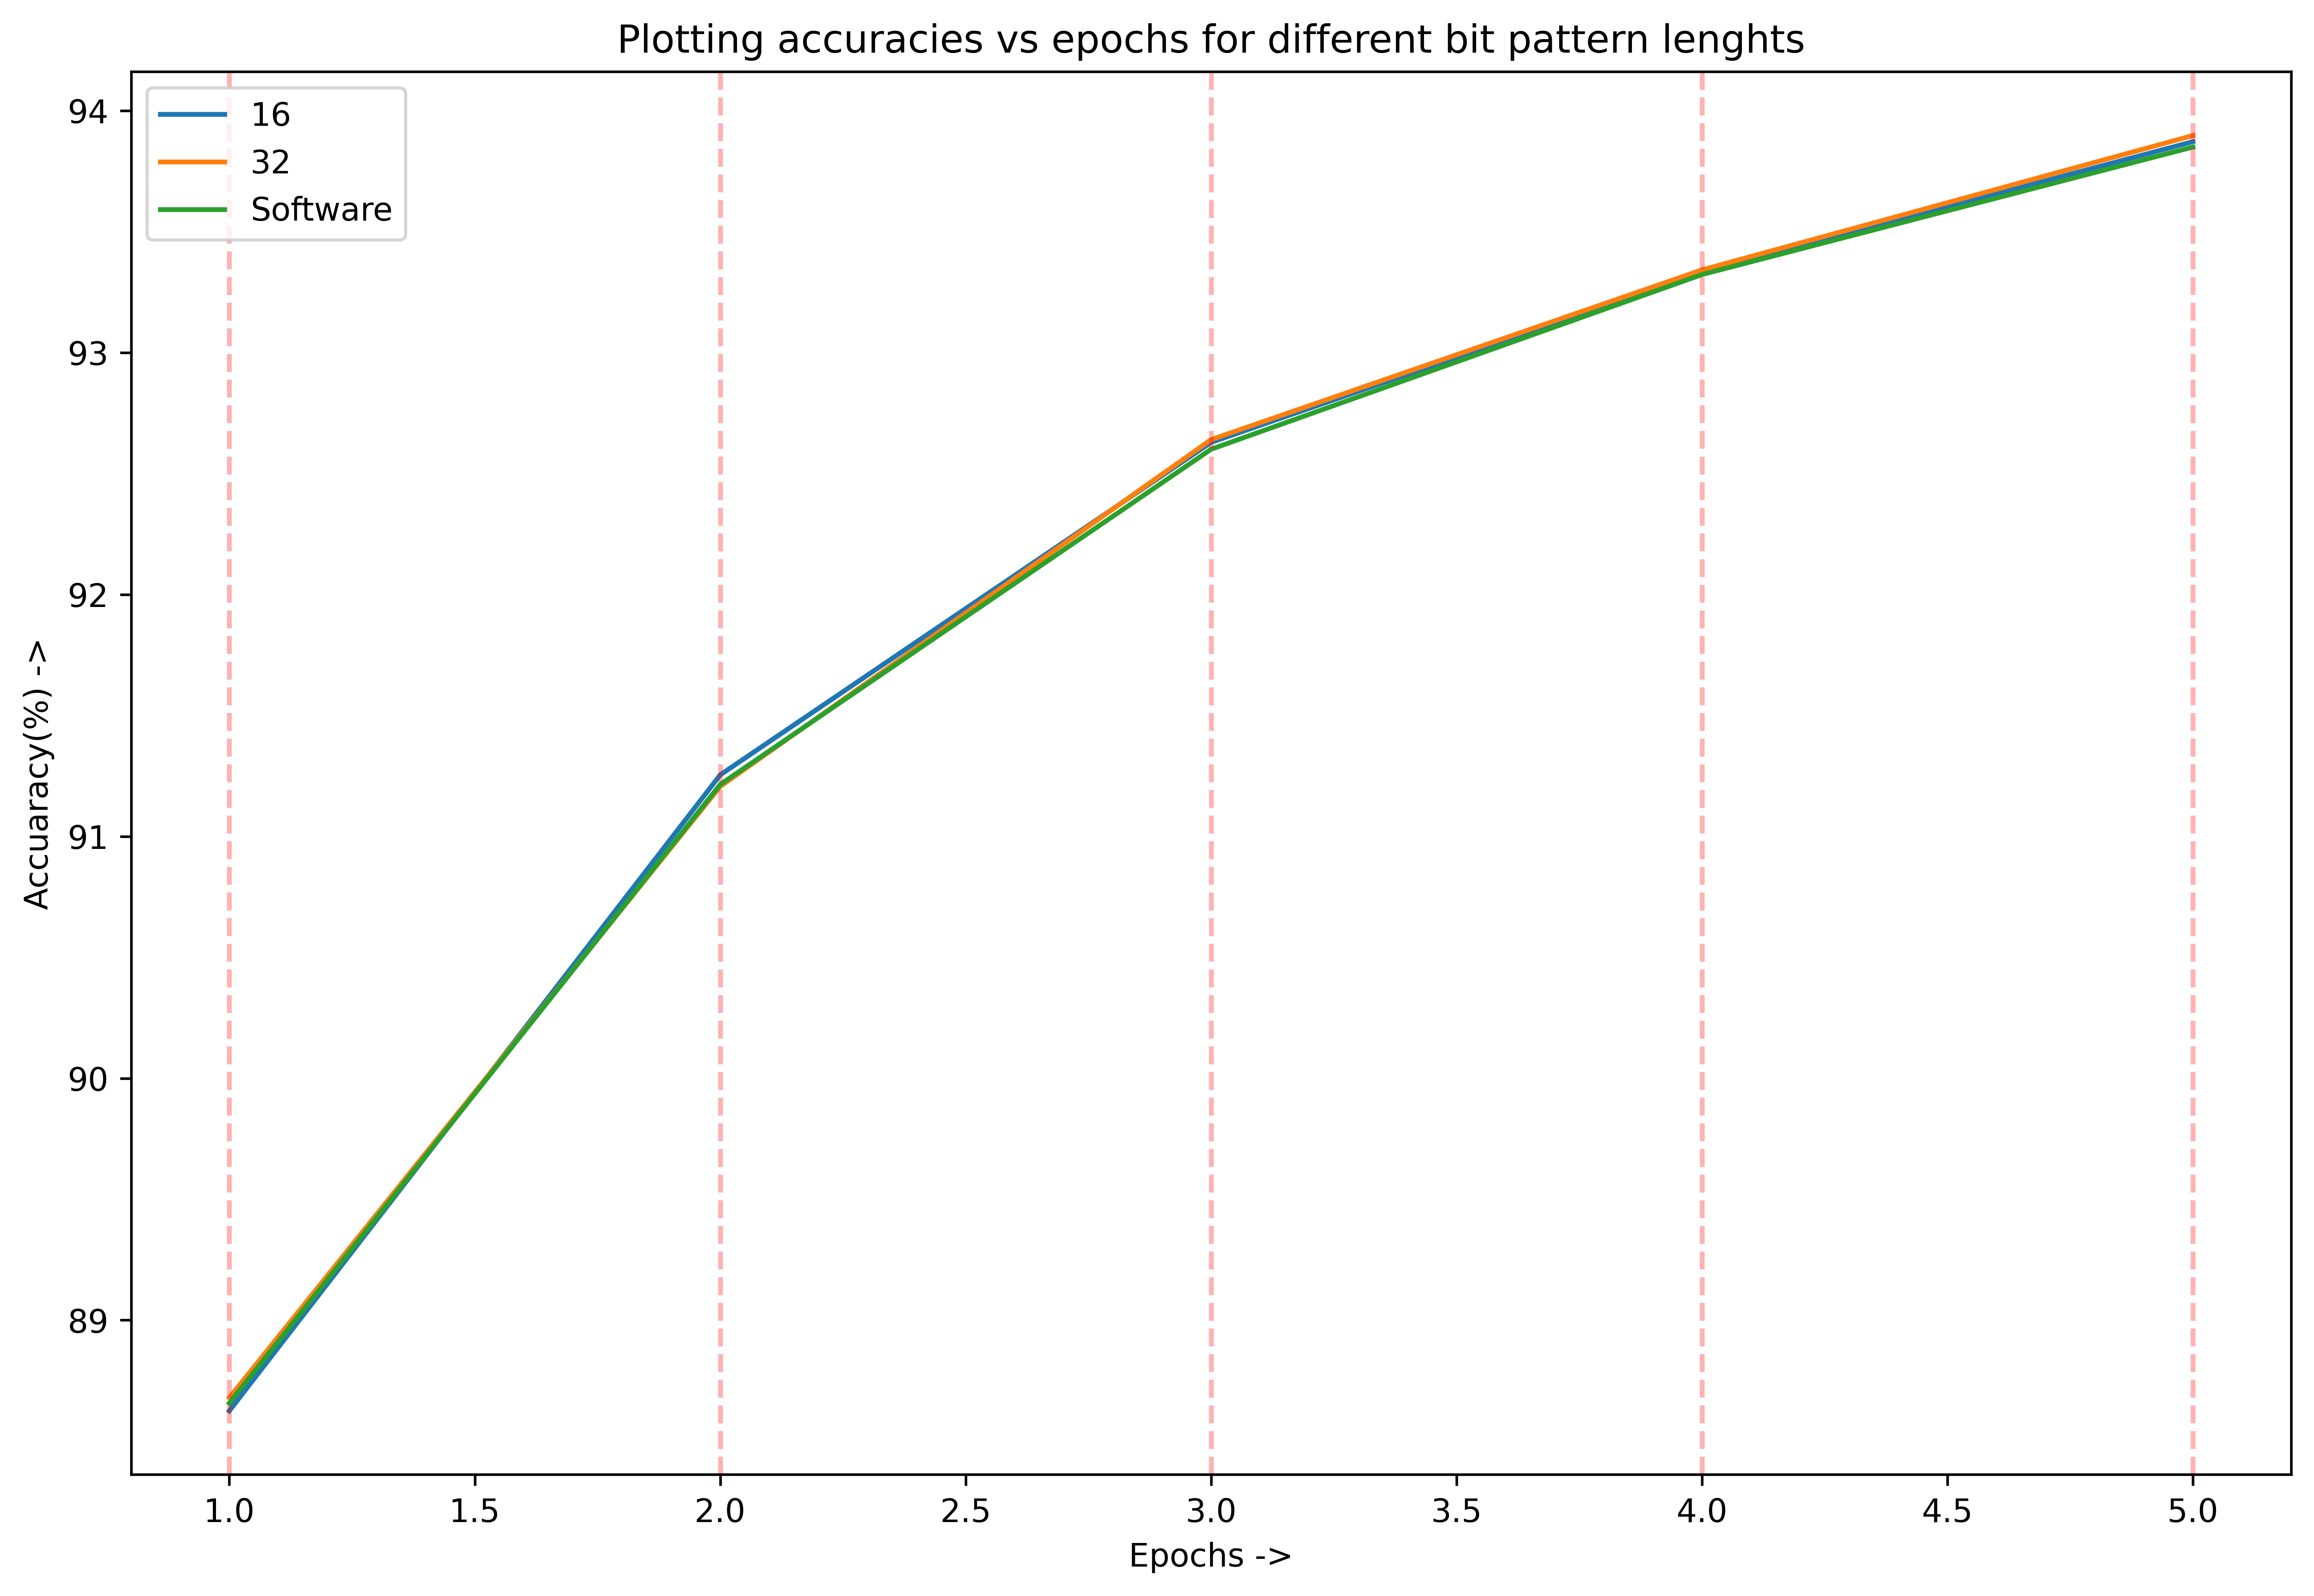

In [84]:
plt.rcParams['figure.dpi'] = 600
leg = []
epoch = [1, 2, 3, 4, 5]
plt.figure(figsize = (12, 8))


for i in [3, 4]:
    leg.append(str(precision[i]))
    plt.plot(epoch, trainAcc1[i])


leg.append("Software")
plt.plot(epoch, train_acc)

for ep in epoch:
    plt.axvline(ep, color = 'r', alpha = 0.3, linestyle = '--')

    

plt.legend(leg)
plt.title("Plotting accuracies vs epochs for different bit pattern lenghts")
plt.xlabel("Epochs ->")
plt.ylabel("Accuaracy(%) ->")

# Back propagation with Quantization

In [97]:
def batchGradDescentBPQaunt(X,Y,iter, lr, precision, step, wRange, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}



  W1, b1, W2, b2 = params_init(2)
  W1 = roundArbitrary(W1, step, wRange)#weights have to maintained as their digitized versions
  b1 = roundArbitrary(b1, step, wRange)
  W2 = roundArbitrary(W2, step, wRange)
  b2 = roundArbitrary(b2, step, wRange)
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      Z1, A1, Z2, A2 = forward(X1, W1, b1, W2, b2) 
      print(f"BP Iter {i+1} -> sub iter {j} : {accuracy(predictions(A2), Y1)}", end = "\r", flush = True)

      #dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)
      #loss = np.sum(crossEntropy(one_hot_encoding(Y1), A2))
      dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1,W2, X1, Y1)



      dW1round = roundArbitrary(dW1, step, wRange)#weights have to maintained as their digitized versions
      db1round = roundArbitrary(db1, step, wRange)
      dW2round = roundArbitrary(dW2, step, wRange)
      db2round = roundArbitrary(db2, step, wRange)


      W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1round, db1round, dW2round, db2round,  lr = lr)


    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _,  A2_train = forward(X, W1, b1, W2, b2)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,   A2_val = forward(x_val, W1, b1, W2, b2)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


In [98]:
precision = [2, 4, 8, 16, 32, 64]
wRange = 1
noOfLevels = [2**precision - 1 for precision in precision] #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  [wRange/nOL for nOL in noOfLevels]

trainAccbp = []
valAccbp = []
trainLossbp = []
valLossbp = []
sWbp = []
for i in range(len(precision)):
    _, _, _, _, train_acc, val_acc, train_loss, val_loss, sum_weights = batchGradDescentBPQaunt(x_train,y_train, iter=10, lr=1, precision=precision[i], step=step[i], wRange = wRange, print_op=1)
    trainAccbp.append(train_acc)
    valAccbp.append(val_acc)
    trainLossbp.append(train_loss)
    valLossbp.append(val_loss)
    sWbp.append(sum_weights)
    print(f"--Done{i}")

Params Initialised
Iteration: 1 sub iter 99 : 20.952380952380953
Train accuracy: 22.55238095238095
Val accuracy: 22.04285714285714
Iteration: 2 sub iter 99 : 21.587301587301593
Train accuracy: 22.892063492063492
Val accuracy: 22.1
Iteration: 3 sub iter 99 : 22.857142857142858
Train accuracy: 24.37142857142857
Val accuracy: 24.285714285714285
Iteration: 4 sub iter 99 : 22.857142857142858
Train accuracy: 24.37142857142857
Val accuracy: 24.285714285714285
Iteration: 5 sub iter 99 : 22.857142857142858
Train accuracy: 24.37142857142857
Val accuracy: 24.285714285714285
Iteration: 6 sub iter 99 : 22.857142857142858
Train accuracy: 24.37142857142857
Val accuracy: 24.285714285714285
Iteration: 7 sub iter 99 : 22.857142857142858
Train accuracy: 24.37142857142857
Val accuracy: 24.285714285714285
Iteration: 8 sub iter 99 : 22.857142857142858
Train accuracy: 24.37142857142857
Val accuracy: 24.285714285714285
Iteration: 9 sub iter 99 : 22.857142857142858
Train accuracy: 24.37142857142857
Val accurac

Text(0, 0.5, 'Accuaracy(%) ->')

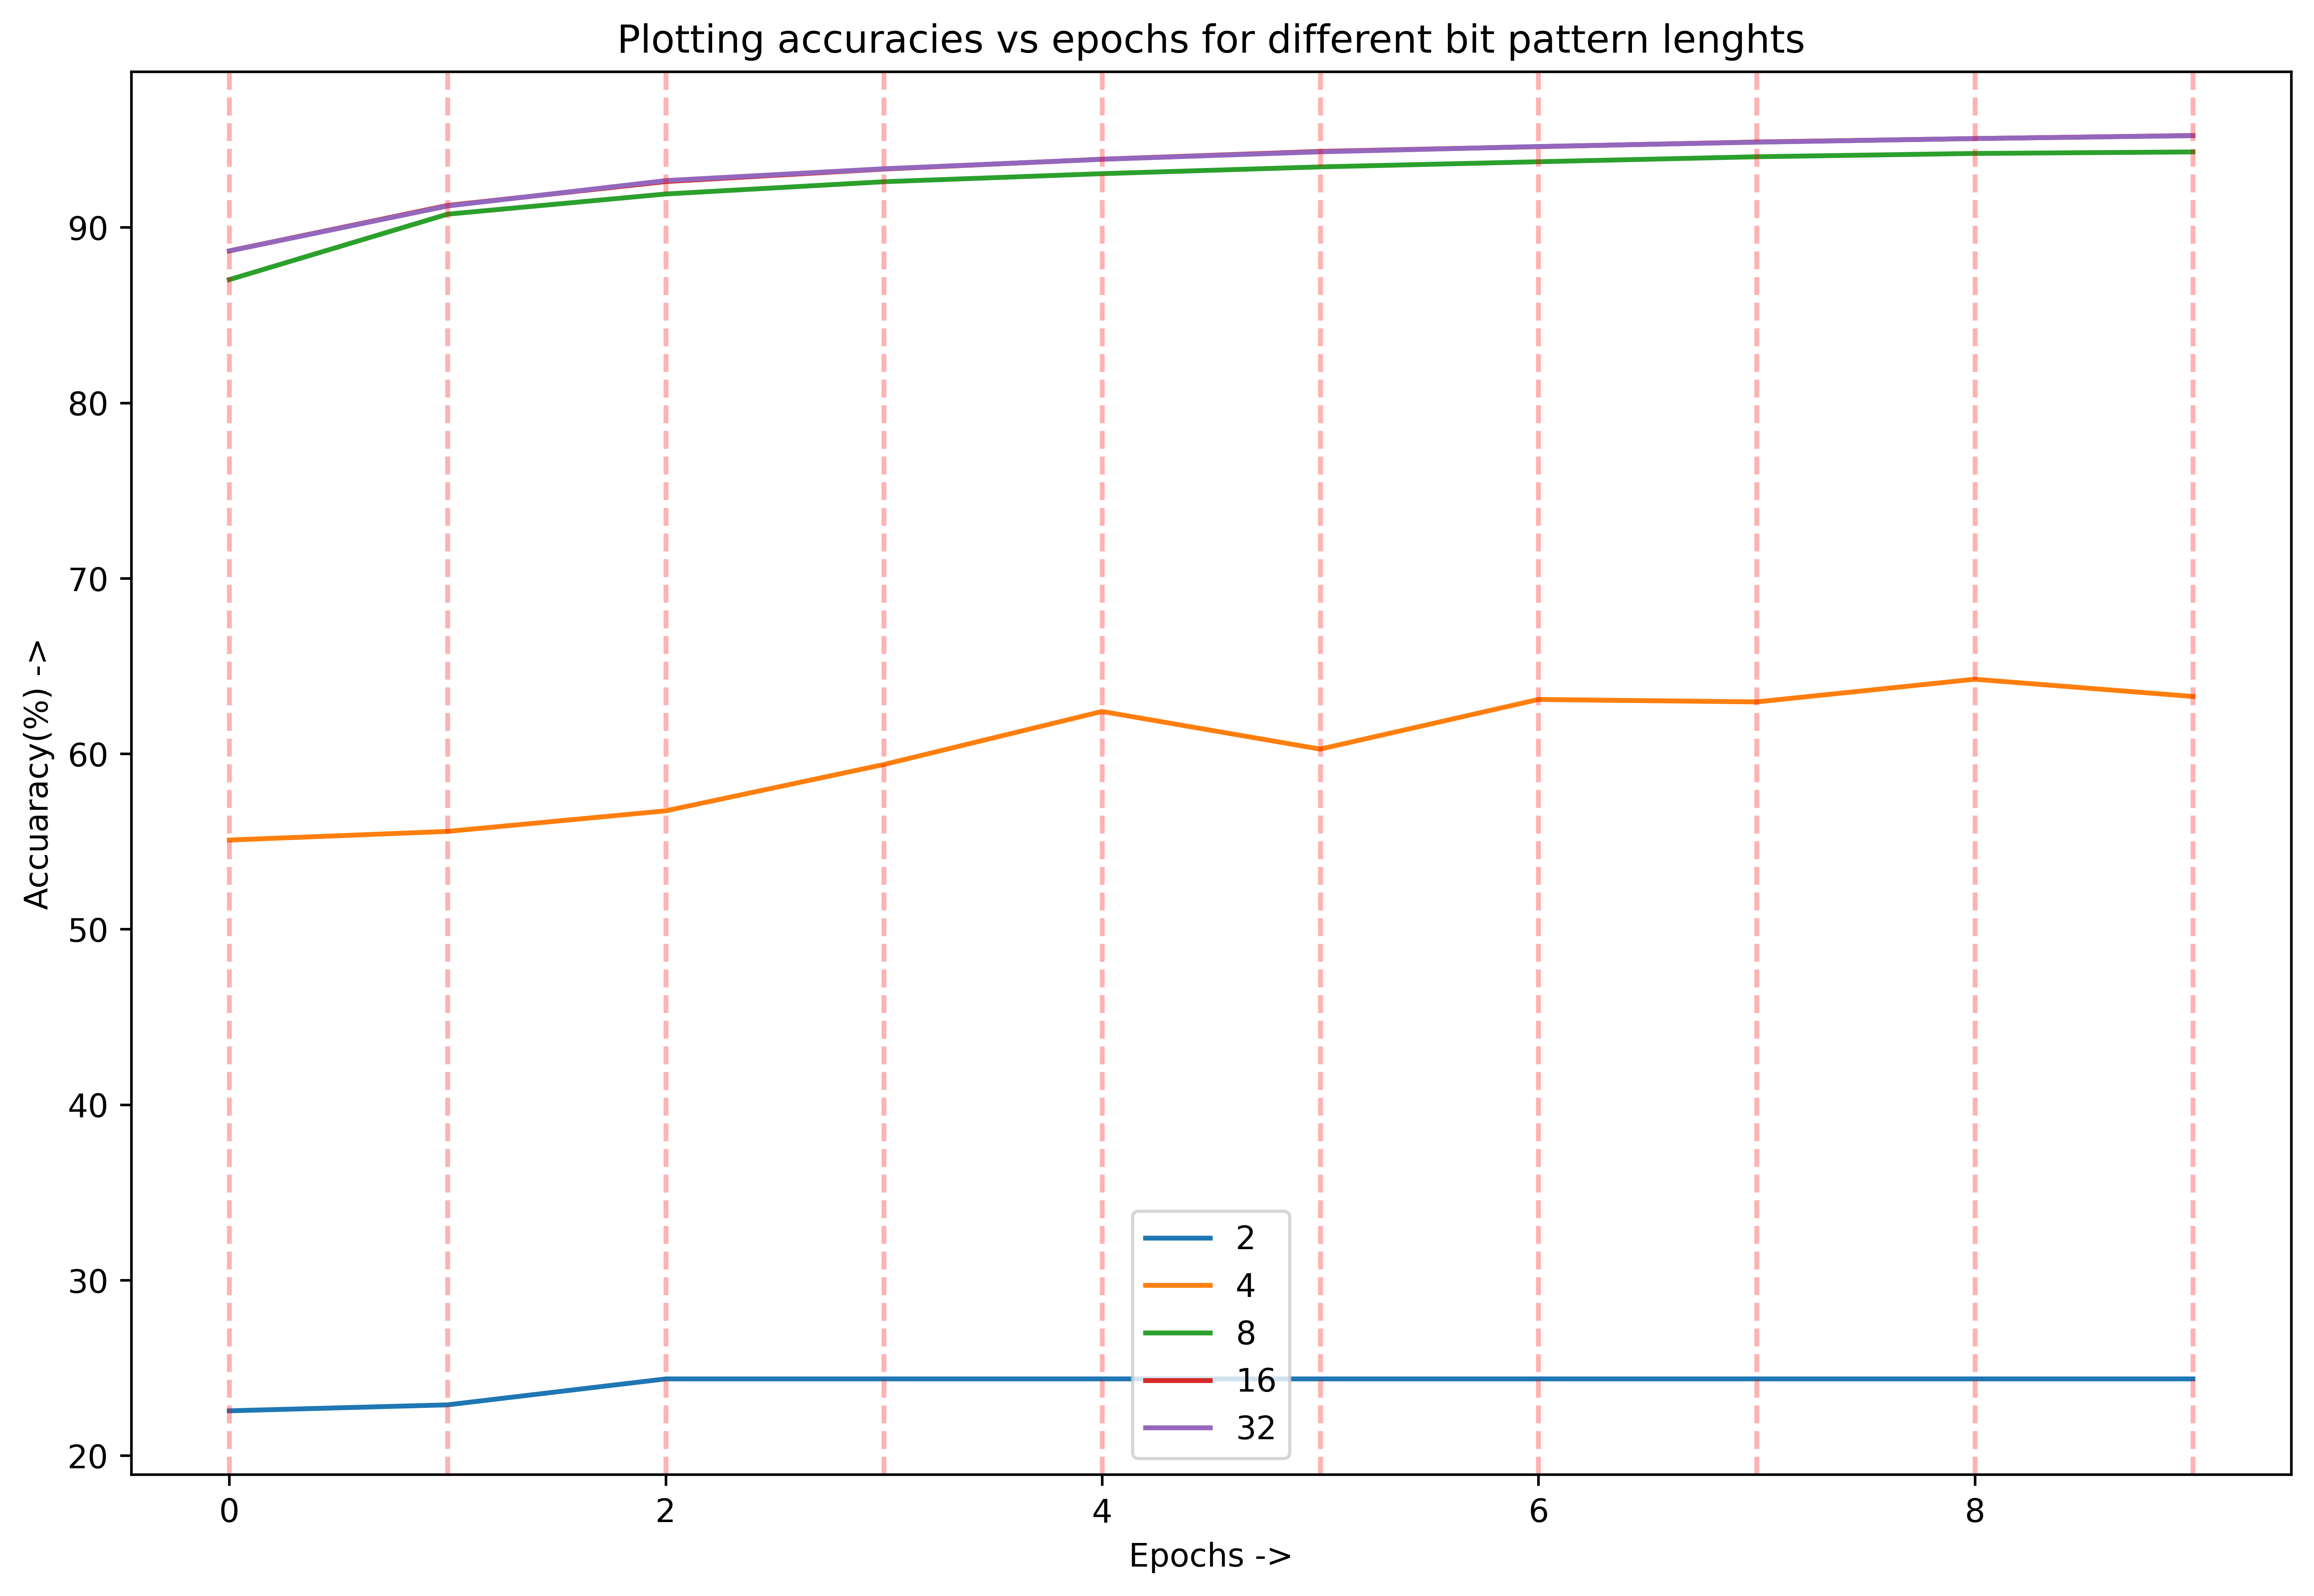

In [102]:
leg = []
epoch = [i for i in range(10)]
plt.figure(figsize = (12, 8))


for i in [0, 1, 2, 3, 4]:
    leg.append(str(precision[i]))
    plt.plot(epoch, trainAccbp[i])


# leg.append("Software")
# plt.plot(epoch, train_acc)

for ep in epoch:
    plt.axvline(ep, color = 'r', alpha = 0.3, linestyle = '--')

    

plt.legend(leg)
plt.title("Plotting accuracies vs epochs for different bit pattern lenghts")
plt.xlabel("Epochs ->")
plt.ylabel("Accuaracy(%) ->")

In [ ]:
WPPPP
Iteration: 1 sub iter 99 : 88.253968253968254
Train accuracy: 88.62539682539683
Val accuracy: 88.58571428571429
Iteration: 2 sub iter 99 : 91.58730158730158
Train accuracy: 91.25396825396825
Val accuracy: 90.97142857142858
Iteration: 3 sub iter 99 : 93.01587301587301
Train accuracy: 92.62857142857143
Val accuracy: 92.24285714285713
Iteration: 4 sub iter 99 : 93.33333333333333
Train accuracy: 93.33174603174604
Val accuracy: 92.75714285714287
Iteration: 5 sub iter 99 : 93.80952380952381
Train accuracy: 93.87142857142857
Val accuracy: 93.05714285714286

In [ ]:
Params Initialised
Iteration: 1 sub iter 99 : 88.095238095238094
Train accuracy: 88.66190476190476
Val accuracy: 88.62857142857142
Iteration: 2 sub iter 99 : 91.58730158730158
Train accuracy: 91.24920634920635
Val accuracy: 90.92857142857143
Iteration: 3 sub iter 99 : 93.01587301587301
Train accuracy: 92.6126984126984
Val accuracy: 92.4
Iteration: 4 sub iter 99 : 93.33333333333333
Train accuracy: 93.32380952380952
Val accuracy: 92.7
Iteration: 5 sub iter 99 : 93.80952380952381
Train accuracy: 93.88571428571429
Val accuracy: 93.07142857142857
Iteration: 6 sub iter 99 : 94.12698412698413
Train accuracy: 94.33015873015873
Val accuracy: 93.37142857142857
Iteration: 7 sub iter 99 : 94.44444444444444
Train accuracy: 94.6015873015873
Val accuracy: 93.74285714285713
Iteration: 8 sub iter 99 : 94.28571428571428
Train accuracy: 94.86666666666666
Val accuracy: 93.85714285714286
Iteration: 9 sub iter 99 : 94.60317460317462
Train accuracy: 95.06190476190476
Val accuracy: 94.18571428571428
Iteration: 10 sub iter 99 : 94.60317460317469
Train accuracy: 95.23650793650795
Val accuracy: 94.42857142857143